# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


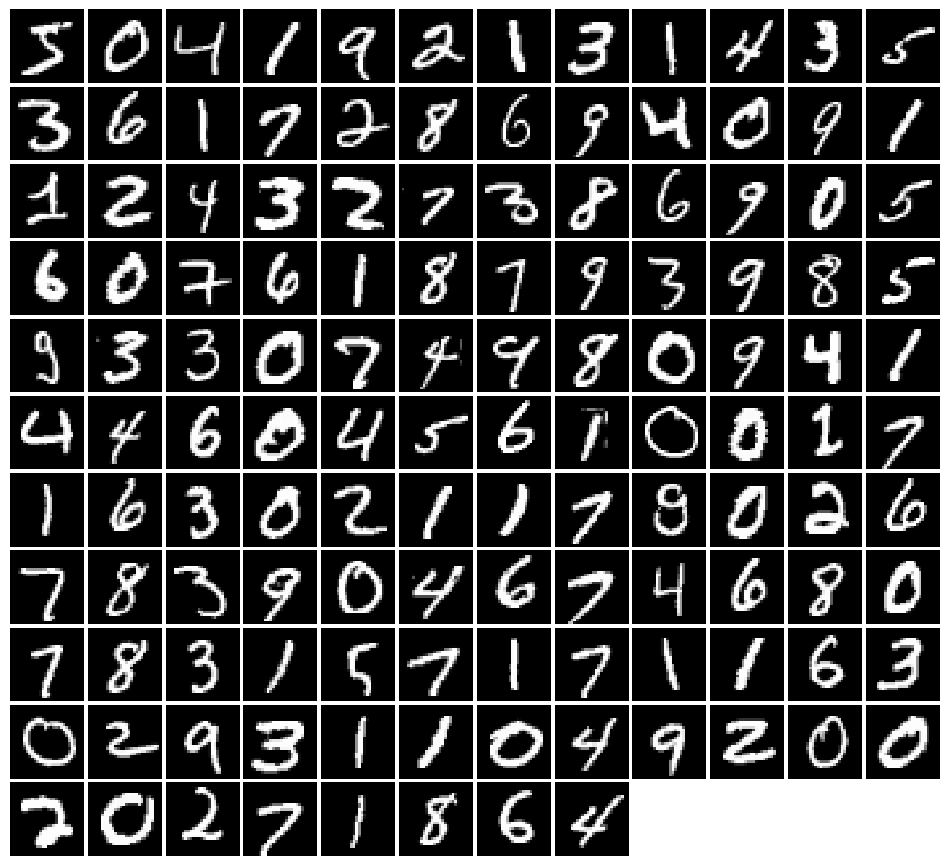

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = next(loader_train.__iter__())[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        Flatten(),
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.378, G:0.6626


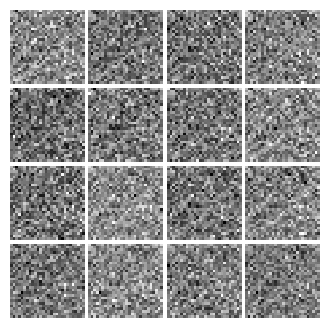


Iter: 250, D: 1.217, G:1.339


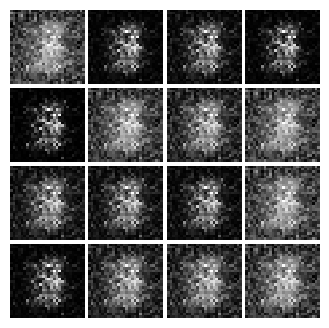


EPOCH:  2
Iter: 500, D: 0.7329, G:1.563


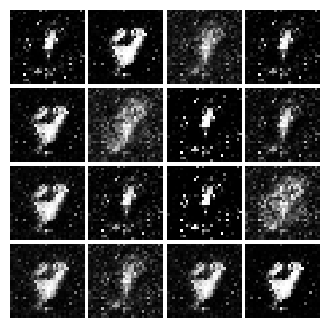


Iter: 750, D: 1.464, G:1.338


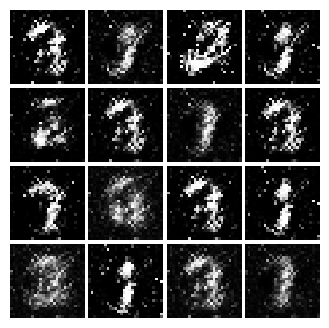


EPOCH:  3
Iter: 1000, D: 1.081, G:1.29


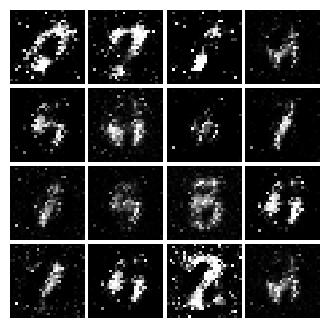


Iter: 1250, D: 1.206, G:1.249


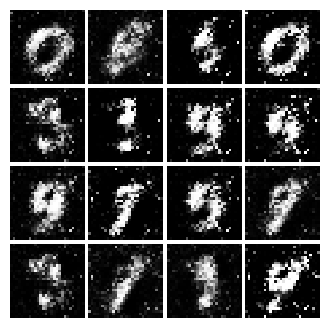


EPOCH:  4
Iter: 1500, D: 1.447, G:0.8117


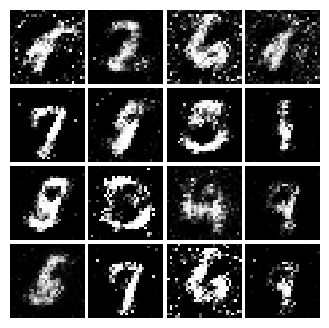


Iter: 1750, D: 1.172, G:1.074


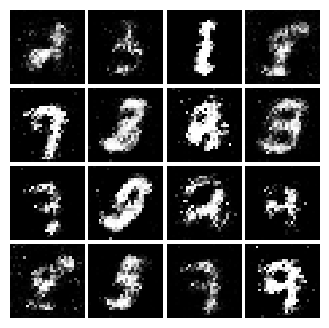


EPOCH:  5
Iter: 2000, D: 1.182, G:0.9525


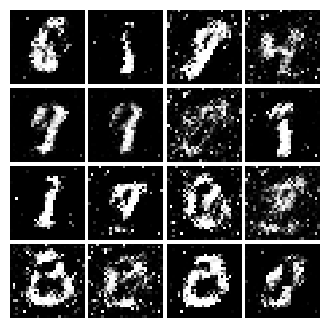


Iter: 2250, D: 1.315, G:1.082


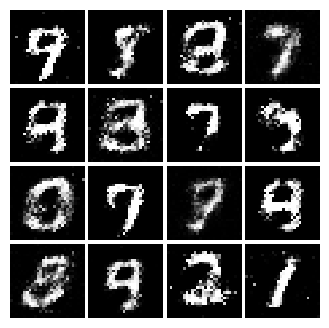


EPOCH:  6
Iter: 2500, D: 1.373, G:0.9734


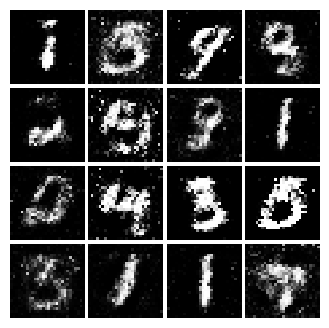


Iter: 2750, D: 1.394, G:0.7817


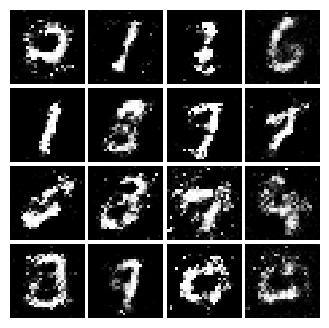


EPOCH:  7
Iter: 3000, D: 1.228, G:0.9633


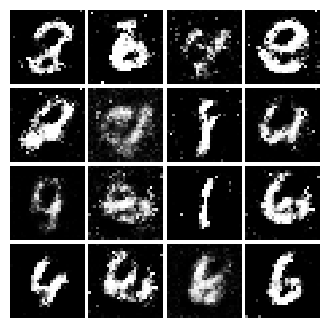


Iter: 3250, D: 1.289, G:0.9479


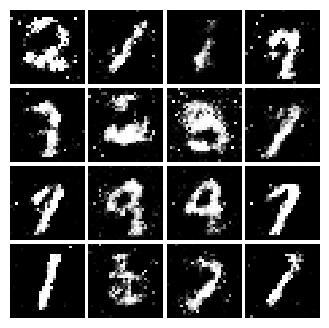


EPOCH:  8
Iter: 3500, D: 1.288, G:0.8976


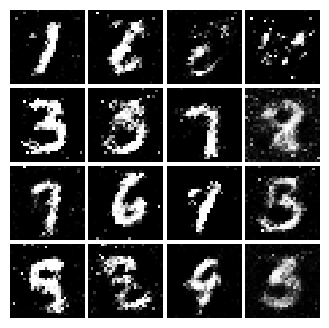


EPOCH:  9
Iter: 3750, D: 1.374, G:0.8192


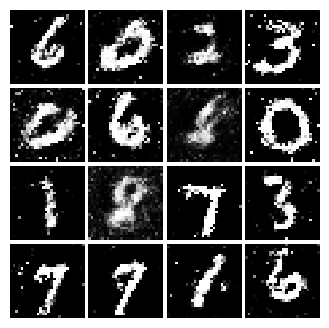


Iter: 4000, D: 1.264, G:0.9654


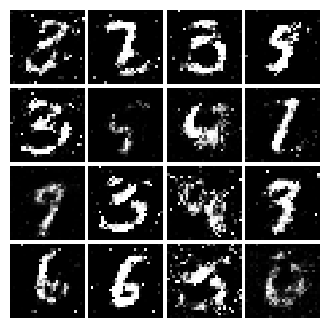


EPOCH:  10
Iter: 4250, D: 1.446, G:0.7046


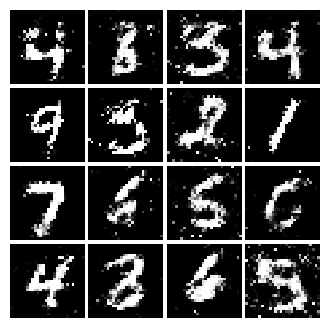


Iter: 4500, D: 1.318, G:0.8391


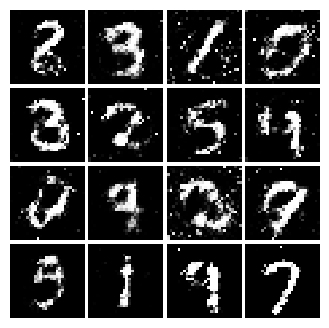

In [8]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5759, G:0.5203


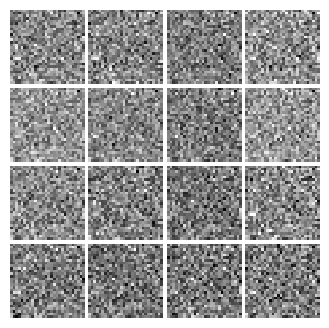


Iter: 250, D: 0.1022, G:0.4029


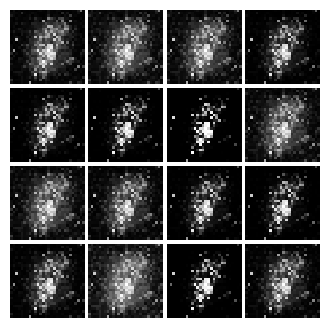


EPOCH:  2
Iter: 500, D: 0.1756, G:0.2214


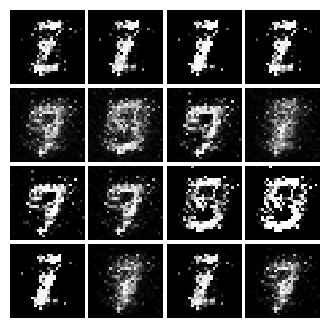


Iter: 750, D: 0.1311, G:0.3038


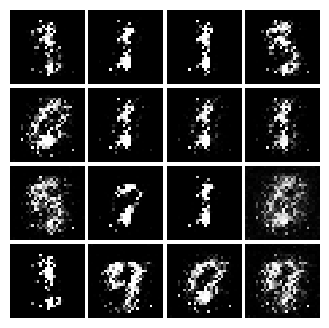


EPOCH:  3
Iter: 1000, D: 0.1675, G:0.3451


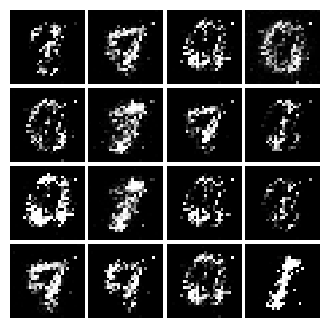


Iter: 1250, D: 0.1318, G:0.9043


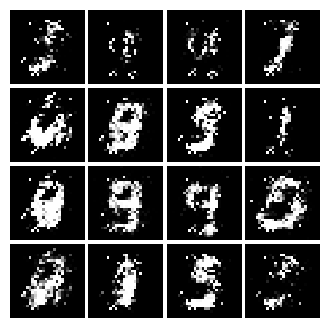


EPOCH:  4
Iter: 1500, D: 0.1754, G:0.1777


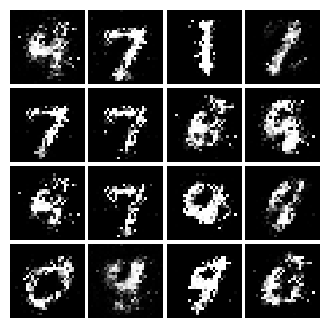


Iter: 1750, D: 0.2136, G:0.3203


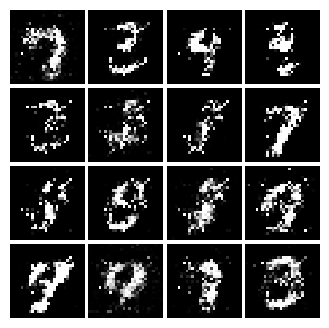


EPOCH:  5
Iter: 2000, D: 0.1821, G:0.2385


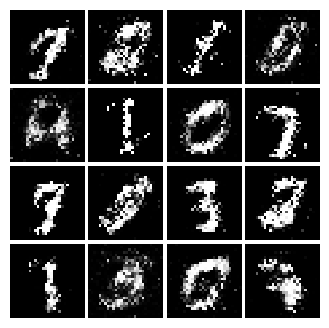


Iter: 2250, D: 0.2155, G:0.1917


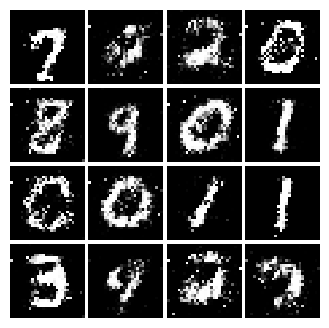


EPOCH:  6
Iter: 2500, D: 0.2122, G:0.1851


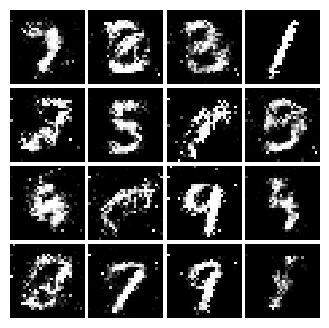


Iter: 2750, D: 0.204, G:0.2004


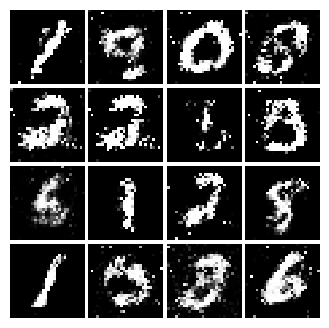


EPOCH:  7
Iter: 3000, D: 0.2288, G:0.1888


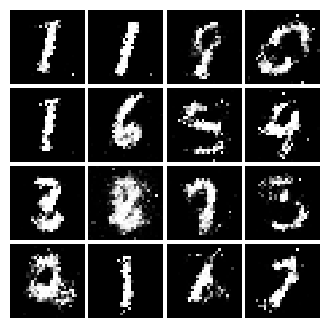


Iter: 3250, D: 0.212, G:0.1893


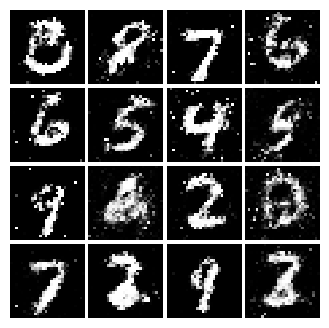


EPOCH:  8
Iter: 3500, D: 0.2378, G:0.1427


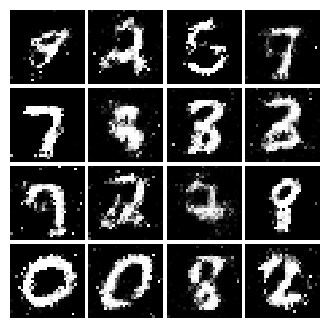


EPOCH:  9
Iter: 3750, D: 0.2202, G:0.1716


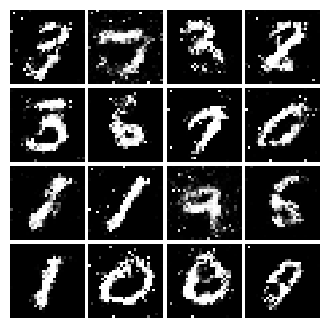


Iter: 4000, D: 0.2487, G:0.1455


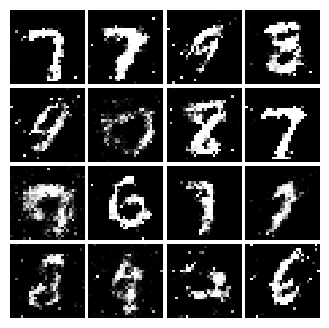


EPOCH:  10
Iter: 4250, D: 0.2303, G:0.181


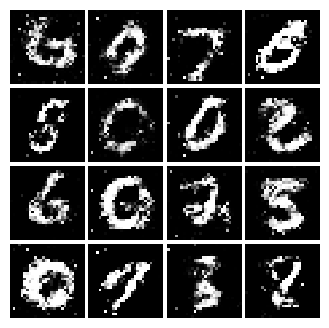


Iter: 4500, D: 0.2531, G:0.1555


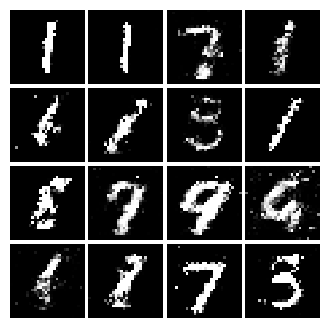

In [9]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)